In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Input
import seaborn as sns
import os
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(tf.__version__)

2.16.1


In [13]:
# Load dataset

# path for pop!_OS
file_name = '/home/csalitre/School/ecgr-4127/tinyml/datasets/hw4_data.csv'

# path for WSL
#file_name = '/home/csalitre/school/ecgr-4127/tinyml/datasets/hw4_data.csv'
df = pd.read_csv(file_name)

df.head(5)

,model_output,prediction,true_class
0,6.039733,1,1
1,2.450787,0,0
2,2.417883,0,1
3,-0.451535,0,0
4,1.173396,0,0


In [7]:
# convert columns to numpy arrays
model_output = df['model_output'].to_numpy()
prediction = df['prediction'].to_numpy()
true_class = df['true_class'].to_numpy()

model_output[:5]

array([ 6.03973338,  2.45078686,  2.4178825 , -0.4515346 ,  1.17339604])

In [8]:
# Find metrics TP, FP, TN, FN, precision and recall
true_positives = ((df['prediction'] == 1) & (df['true_class'] == 1)).sum()
false_positives = ((df['prediction'] == 1) & (df['true_class'] == 0)).sum()
true_negatives = ((df['prediction'] == 0) & (df['true_class'] == 0)).sum()
false_negatives = ((df['prediction'] == 0) & (df['true_class'] == 1)).sum()

precision = round(true_positives / (true_positives + false_positives), 4)
recall = round(true_positives / (true_positives + false_negatives), 4)

print(f"True Positives: {true_positives}")
print(f"False Positives: {false_negatives}")
print(f"True Negatives: {true_negatives}")
print(f"False Negatives: {false_negatives}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

True Positives: 26
False Positives: 21
True Negatives: 150
False Negatives: 21
Precision: 0.8966
Recall: 0.5532


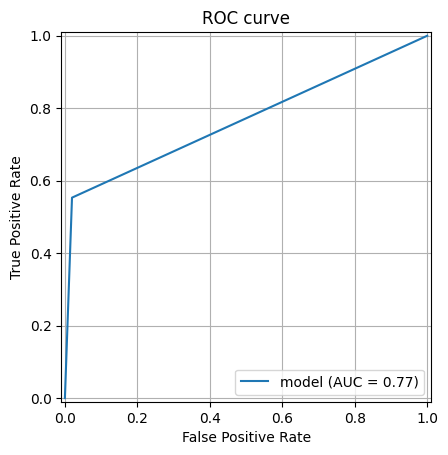

In [9]:
# Plot ROC curve
fpr, tpr, threshold = metrics.roc_curve(true_class, prediction)
roc_auc = metrics.auc(fpr, tpr)

metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='model').plot()

plt.title('ROC curve')
plt.grid(True)
plt.show()


In [10]:
#find the minimum FP rate you can achieve to correctly detect at least 90% of all actual positives
#FP = (true positives/precision) - true positives -- precision = 0.9
min_false_positives = (true_positives / precision) - true_positives
print(f"The minimum False Positive Rate: {min_false_positives}")

The minimum False Positive Rate: 2.998438545616775


In [19]:
# Load the Dataset
directory = '/home/csalitre/School/ecgr-4127/sports_cars'

def load_images(directory, target_size=(32, 32)):
    images = []
    labels = []  # 1 for positive, 0 for negative

    # Load positive images
    for filename in os.listdir(os.path.join(directory, 'positive')):
        img = load_img(os.path.join(directory, 'positive', filename), target_size=target_size)
        img = img_to_array(img)
        images.append(img)
        labels.append(1)

    # Load negative images
    for filename in os.listdir(os.path.join(directory, 'negative')):
        img = load_img(os.path.join(directory, 'negative', filename), target_size=target_size)
        img = img_to_array(img)
        images.append(img)
        labels.append(0)

    return np.array(images), np.array(labels)

# Assuming you have a small number of images, you might not have a separate test set
all_train_images, all_train_labels = load_images(directory)
#all_test_images, all_test_labels = load_images(directory)


# Normalize the images
all_train_images = all_train_images / 255.0
#all_test_images = all_test_images / 255.0